# Unsupervised Classification

## Load imports.

In [1]:
# Make common scripts visible and unsupervised classifier code
import sys
sys.path.append('../common/')
sys.path.append('../kb-classifier/')

import numpy as np
import nltk
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from reuters_parser import load_data
from lookup_tables import topic_code_to_topic_dict, topic_code_to_int, int_to_topic_code
from sentence_utils import remove_stop_words_and_lemmatize
from conversion import convert_dictionary_to_array
from kb_classifier_copy import KnowledgeBasePredictor
from kb_common import int_to_topic

## Load the data.

In [2]:
def sanitise_each_topic(text):      
    return remove_stop_words_and_lemmatize(text, lowercase=False, lemmatize=False, keep_nouns_only=True)


year_data = load_data('19960820', '19970819', '../../../downloads/reuters/rcv1/', topic_code_to_topic_dict)
#year_data = load_data('19960820', '19960830', '../../../downloads/reuters/rcv1/', topic_code_to_topic_dict)

# For accurate comparison with the Naive Bayes classifier, keep the last 20% of documents using the same random seed.
# I.e. we are making predictions on the same test set.
np.random.seed(42)

# Get 20% test
x, y = convert_dictionary_to_array(year_data, topic_code_to_int)
total_examples = len(y)
split_point = int(total_examples * 0.8)
test_x = np.array(list(map(sanitise_each_topic, x[split_point:])))
test_y = y[split_point:]


# Take 20 documents of each type from the training set for classifier tuning
train_x = []
train_y = np.zeros(shape=7200)

counts = np.zeros(shape=len(topic_code_to_int.keys()))
current_index = 0
print(split_point)
for i in range(split_point):
    topic_int = y[i]
    
    if counts[topic_int] < 1200:
        train_x.append(x[i])
        train_y[current_index] = topic_int
        counts[topic_int] += 1
        current_index += 1

train_x = np.array(list(map(sanitise_each_topic, train_x)))
print(counts)

73723
[1200. 1200. 1200. 1200. 1200. 1200.]


## Initialise and tune class probabilities for unsupervised learner

In [3]:
np.random.seed(42)
kb_predictor = KnowledgeBasePredictor(topic_code_to_topic_dict.values())
kb_predictor.train(train_x, train_y)

In [4]:
predict_y = kb_predictor.predict(train_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(train_y, predict_y)

print(classification_report)
print(confusion_matrix)

                        precision    recall  f1-score   support

CRIME, LAW ENFORCEMENT   1.000000  1.000000  1.000000      1200
  ECONOMIC PERFORMANCE   1.000000  1.000000  1.000000      1200
             ELECTIONS   1.000000  1.000000  1.000000      1200
                HEALTH   1.000000  1.000000  1.000000      1200
              RELIGION   1.000000  1.000000  1.000000      1200
                SPORTS   1.000000  1.000000  1.000000      1200

             micro avg   1.000000  1.000000  1.000000      7200
             macro avg   1.000000  1.000000  1.000000      7200
          weighted avg   1.000000  1.000000  1.000000      7200

[[1200    0    0    0    0    0]
 [   0 1200    0    0    0    0]
 [   0    0 1200    0    0    0]
 [   0    0    0 1200    0    0]
 [   0    0    0    0 1200    0]
 [   0    0    0    0    0 1200]]


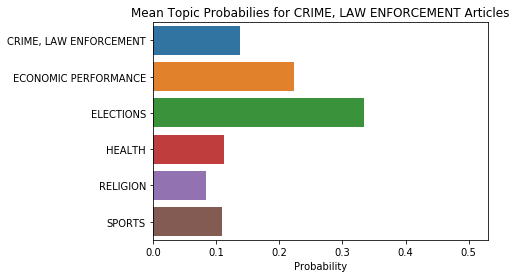

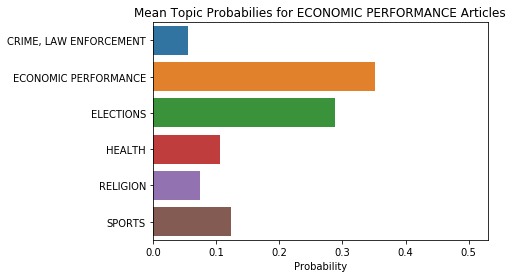

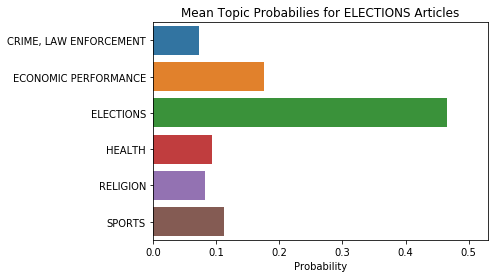

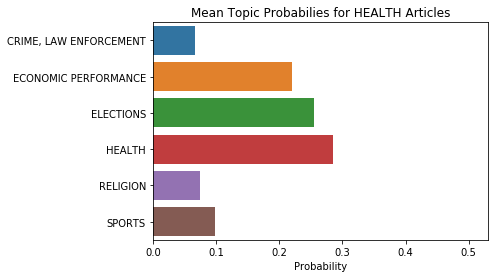

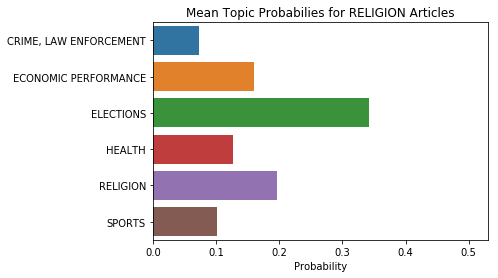

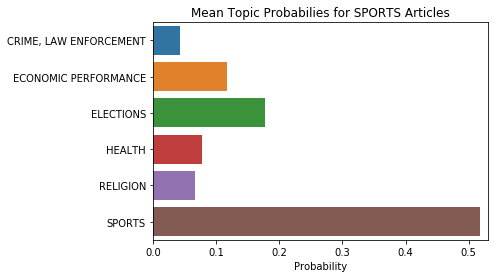

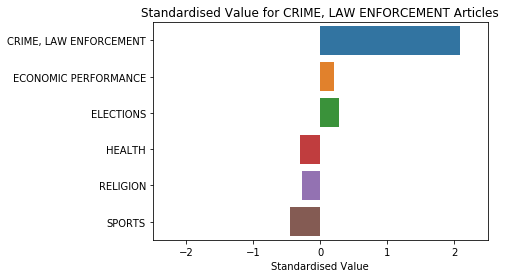

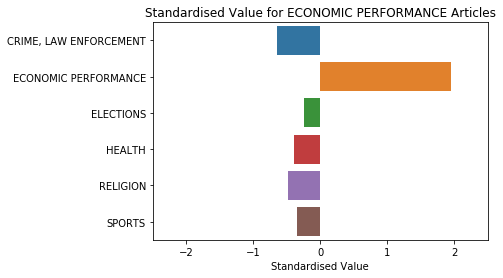

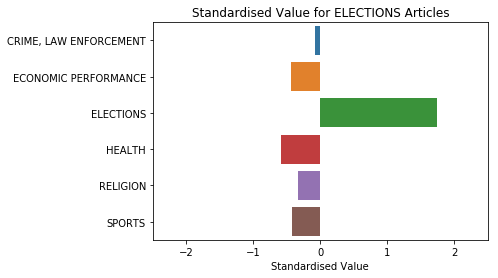

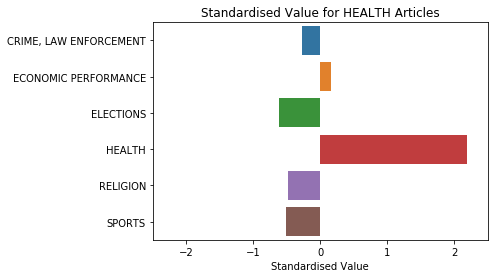

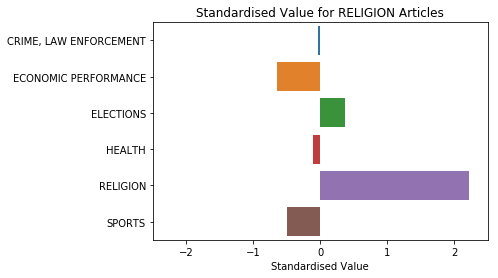

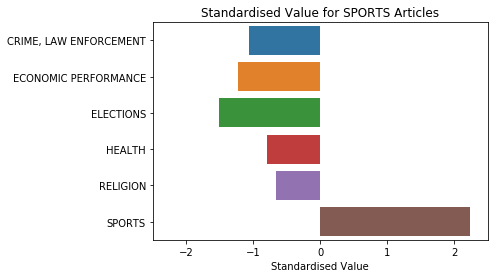

In [ ]:
prob_means = np.zeros(shape=(6, 6))

# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_means[index] = prob_mean
    
    plt.figure()
    plt.title('Mean Topic Probabilies for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Probability')
    plt.xlim(0.0, 0.53)
    sns.barplot(x=prob_mean, y=list(int_to_topic.values()))
    plt.savefig('topic_prob_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()
    
# Plot graph of mean topic probabilities for each topic class
for index, topic_code in int_to_topic_code.items():
    prob_mean = np.mean(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    prob_std = np.std(kb_predictor.last_class_probabilities[train_y == index], axis=0)
    
    plt.figure()
    plt.title('Standardised Value for {} Articles'.format(topic_code_to_topic_dict[topic_code]))
    plt.xlabel('Standardised Value')
    plt.xlim(-2.5, 2.5)
    sns.barplot(x=((prob_mean-np.mean(prob_means, axis=0))/np.std(prob_means, axis=0)),
                   y=list(int_to_topic.values()))
    plt.savefig('standardised_{}.pdf'.format(topic_code_to_topic_dict[topic_code]), bbox_inches='tight')
    plt.show()

## Assess unsupervised classifier performance.

In [ ]:
print('Making predictions for {} documents'.format(len(test_y)))
predict_y = kb_predictor.predict(test_x)
classification_report, confusion_matrix = kb_predictor.get_classification_report(test_y, predict_y)

print(classification_report)
print(confusion_matrix)

Making predictions for 18431 documents
